# Set Up

## Imports

In [175]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CBFV import composition
from sklearn.metrics import r2_score, mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Multiply, Concatenate, Activation, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, AdamW
from datetime import datetime
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import shap

In [176]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

## Seed and Paths

In [177]:
RNG_SEED = 8
np.random.seed(RNG_SEED)
curr_dir = os.getcwd()
DATA_PATH = os.path.join(os.path.dirname(curr_dir), 'Data')
MODELS_PATH = os.path.join(os.path.dirname(curr_dir), 'Models')
WEIGHTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Weights')
ASSETS_PATH = os.path.join(os.path.dirname(curr_dir), 'Assets')
RESULTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Results')

# Data

## Collection

In [178]:
df_train = pd.read_csv(os.path.join(DATA_PATH, "intermetallics_train7.csv"))
df_val = pd.read_csv(os.path.join(DATA_PATH, "intermetallics_val7.csv"))
df_test = pd.read_csv(os.path.join(DATA_PATH, "intermetallics_test7.csv"))

## Preprocessing

In [179]:
df_train = df_train.drop_duplicates()
df_val = df_val.drop_duplicates()
df_test = df_test.drop_duplicates()

In [180]:
drop_columns = ['composition', 'material_id', 'structure',
                'total_magnetization', 'total_magnetization_normalized_vol']
df_train.drop(
    columns=[col for col in drop_columns if col in df_train.columns], inplace=True)
df_val.drop(
    columns=[col for col in drop_columns if col in df_val.columns], inplace=True)
df_test.drop(
    columns=[col for col in drop_columns if col in df_test.columns], inplace=True)


df_train.to_csv(os.path.join(
    DATA_PATH, 'trainSet_columnOrder.csv'), index=False)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (5197, 1594)
df_val DataFrame shape: (1504, 1594)
df_test DataFrame shape: (747, 1594)


In [181]:
rename_dict = {'total_magnetization_normalized_formula_units': 'target'}

df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(
    df_train, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(
    df_val, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(
    df_test, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

columns = X_train_unscaled.columns.values.tolist()

Processing Input Data: 100%|██████████| 5197/5197 [00:00<00:00, 51568.74it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5197/5197 [00:00<00:00, 36601.18it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1504/1504 [00:00<00:00, 54530.81it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1504/1504 [00:00<00:00, 35633.09it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 747/747 [00:00<00:00, 53772.21it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 747/747 [00:00<00:00, 35544.14it/s]


	Creating Pandas Objects...


In [182]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

# X_train = normalize(X_train)
# X_val = normalize(X_val)
# X_test = normalize(X_test)

In [183]:
X_train_new = np.concatenate((X_train, X_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(X_train_new.shape)

(6701, 1746)


In [184]:
enc = OrdinalEncoder()

df_train_new = pd.concat((df_train, df_val), axis=0)
enc.fit(df_train_new[["formula", "number"]])
df_train_new[["formula", "number"]] = enc.transform(
    df_train_new[["formula", "number"]])

In [185]:
def run_pca(X_train, X_test, variance_threshold=0.95):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)

    explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
    n_components_optimal = np.argmax(
        explained_variance_ratio >= variance_threshold) + 1
    print(
        f"Optimal number of components to retain {variance_threshold * 100}% variance: {n_components_optimal}")

    pca_optimal = PCA(n_components=n_components_optimal)
    X_train_reduced = pca_optimal.fit_transform(X_train)
    X_test_reduced = pca_optimal.transform(X_test)

    return X_train_reduced, X_test_reduced, n_components_optimal, pca_optimal

In [186]:
X_train_reduced, X_test_reduced, n_components, pca_model = run_pca(
    X_train_new, X_test)
print(f"Reduced training set shape: {X_train_reduced.shape}")
print(f"Reduced test set shape: {X_test_reduced.shape}")

Optimal number of components to retain 95.0% variance: 110
Reduced training set shape: (6701, 110)
Reduced test set shape: (747, 110)


# Models

## Custom

### Training

In [187]:
def build_advanced_regression_model(input_shape, dropout_rate=0.5, weight_decay=1e-4):
    # Input layer
    inputs = Input(shape=(input_shape,))

    # First dense block
    x = Dense(512, activation=None,
              kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Skip connection 1
    skip1 = Dense(256, activation=None,
                  kernel_regularizer=l2(weight_decay))(inputs)
    skip1 = BatchNormalization()(skip1)
    skip1 = Activation('relu')(skip1)

    # Second dense block
    x = Dense(256, activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Add skip connection 1
    x = Add()([x, skip1])

    # Third dense block
    x = Dense(128, activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    # Skip connection 2
    skip2 = Dense(128, activation=None,
                  kernel_regularizer=l2(weight_decay))(inputs)
    skip2 = BatchNormalization()(skip2)
    skip2 = Activation('relu')(skip2)
    x = Add()([x, skip2])

    # Fourth dense block
    x = Dense(64, activation='relu', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    output = Dense(1, activation='linear')(x)

    # Define the model
    model = Model(inputs, output)
    model.compile(
        optimizer=AdamW(learning_rate=1e-3),
        loss='mean_squared_error',
        metrics=['root_mean_squared_error']
    )

    return model

In [188]:
input_shape = X_train.shape[1]

model = build_advanced_regression_model(input_shape)

model.summary()

lr_scheduler = ReduceLROnPlateau(
    monitor='val_root_mean_squared_error', factor=0.5, patience=10, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[lr_scheduler],

    verbose=1
)

test_loss, test_rmse = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test RMSE: {test_rmse:.4f}")

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1746)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 512)       │    894,464 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_42[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 512)       │          0 │ activation_30[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 256)       │    131,328 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_44[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 256)       │    447,232 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_43[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ activation_32[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 256)       │          0 │ dropout_21[0][0], │
│                     │                   │            │ activation_31[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 128)       │     32,896 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_45[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 128)       │    223,616 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_46[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,742,977 (6.65 MB)

 Trainable params: 1,740,417 (6.64 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 71.4369 - root_mean_squared_error: 8.3957 - val_loss: 30.9732 - val_root_mean_squared_error: 5.5451 - learning_rate: 0.0010
Epoch 2/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 41.4613 - root_mean_squared_error: 6.4081 - val_loss: 30.3420 - val_root_mean_squared_error: 5.4868 - learning_rate: 0.0010
Epoch 3/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 35.7304 - root_mean_squared_error: 5.9495 - val_loss: 22.4852 - val_root_mean_squared_error: 4.7156 - learning_rate: 0.0010
Epoch 4/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 36.0221 - root_mean_squared_error: 5.9661 - val_loss: 29.8334 - val_root_mean_squared_error: 5.4381 - learning_rate: 0.0010
Epoch 5/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 27.2810 - root_mean_squared_error: 5.1964 - val_loss: 23.2674 - val_root_mean_squared_error: 4.7955 - learning_rate: 0.0010
Epoch 6/150
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 22.8871 

### Evaluation

In [189]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R-squared: 0.8494
Root Mean Squared Error: 3.5094


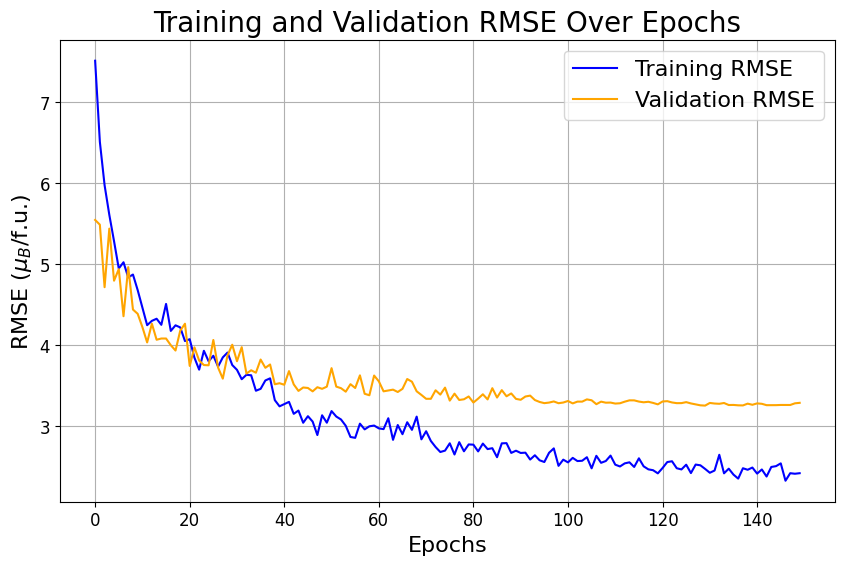

In [190]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'],
         label='Training RMSE', color='blue')
plt.plot(history.history['val_root_mean_squared_error'],
         label='Validation RMSE', color='orange')

plt.title('Training and Validation RMSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE ($\u03bc_B$/f.u.)')
plt.legend()
plt.grid(True)
plt.show()

In [191]:
y_test = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

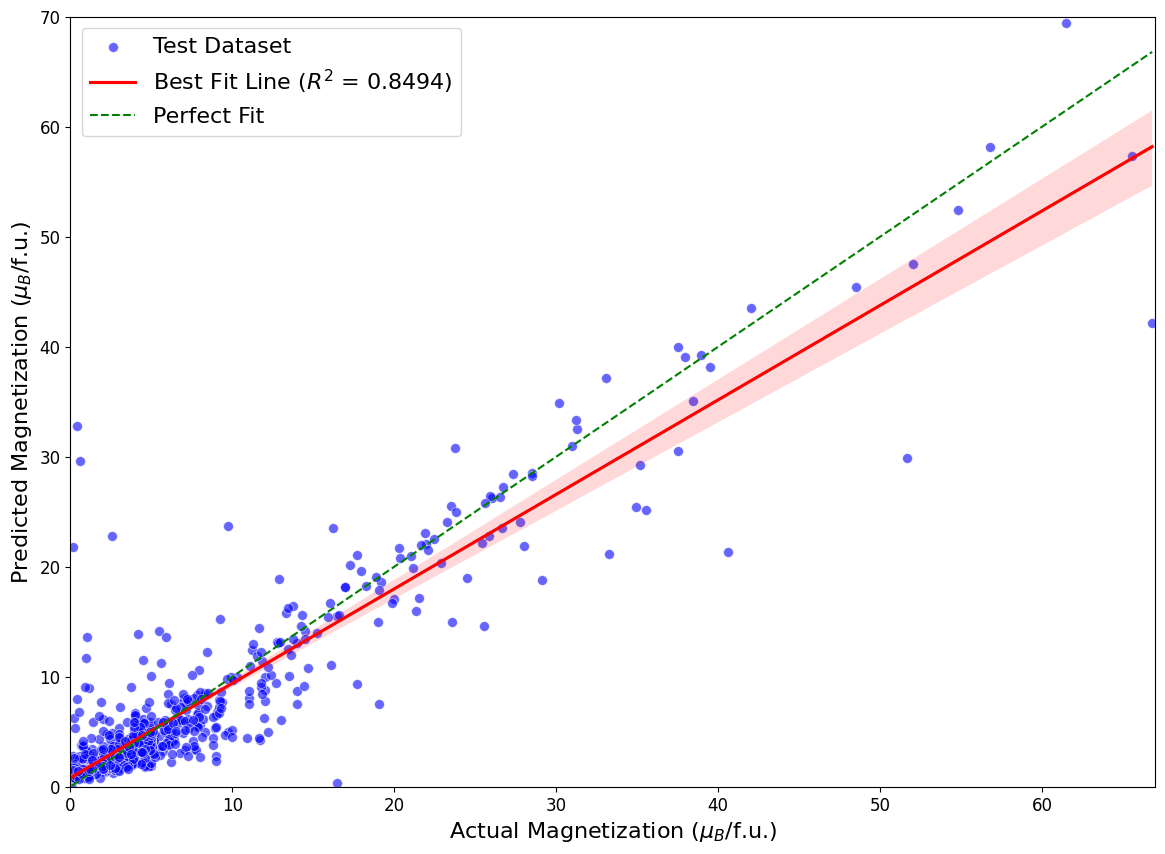

In [192]:
plt.figure(figsize=(14, 10))

r2 = r2_score(y_test, y_pred)

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

sns.scatterplot(x=y_test, y=y_pred, color='blue',
                alpha=0.6, s=50, label='Test Dataset')

sns.regplot(x=y_test, y=y_pred, scatter=False,
            color='red', label=f'Best Fit Line ($R^2$ = {round(r2, 4)})')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='green', linestyle='--', label='Perfect Fit')

plt.ylabel('Predicted Magnetization ($\u03bc_B$/f.u.)')
plt.xlabel('Actual Magnetization ($\u03bc_B$/f.u.)')
plt.xlim([0, 67])
plt.ylim([0, 70])
plt.legend()
plt.show()

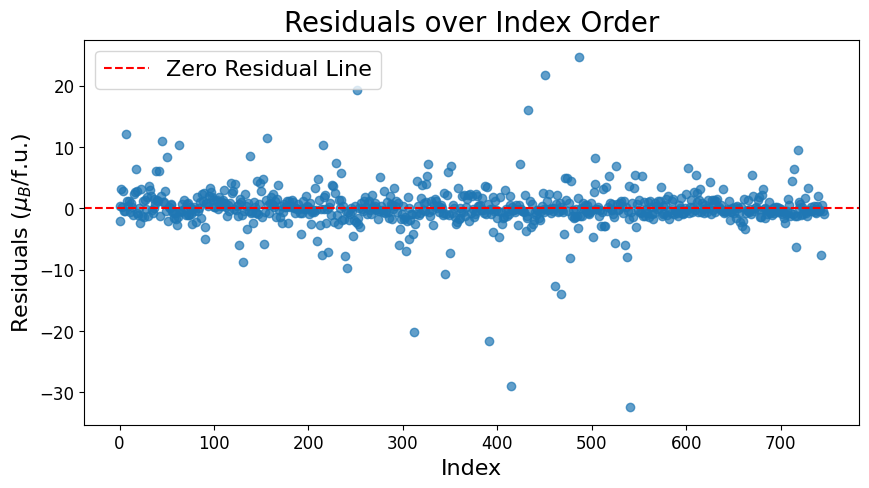

In [193]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.plot(residuals, marker='o', linestyle='', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals over Index Order')
plt.xlabel('Index')
plt.ylabel('Residuals ($\u03bc_B$/f.u.)')
plt.legend()
plt.show()

In [194]:
df_lit = pd.read_csv(DATA_PATH + "/test/real_data.csv")
df_truth = pd.read_csv(DATA_PATH + "/test/real_results.csv")

In [195]:
df_lit = df_lit.rename(columns=rename_dict)

In [196]:
X_lit_unscaled, y_lit, formulae_pred, skipped_pred = composition.generate_features(
    df_lit, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 19/19 [00:00<00:00, 41291.08it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 19/19 [00:00<00:00, 27854.52it/s]

	Creating Pandas Objects...


In [197]:
X_lit = scaler.transform(X_lit_unscaled)

In [198]:
y_pred = model.predict(X_lit)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [199]:
y_pred = np.array(y_pred).flatten()

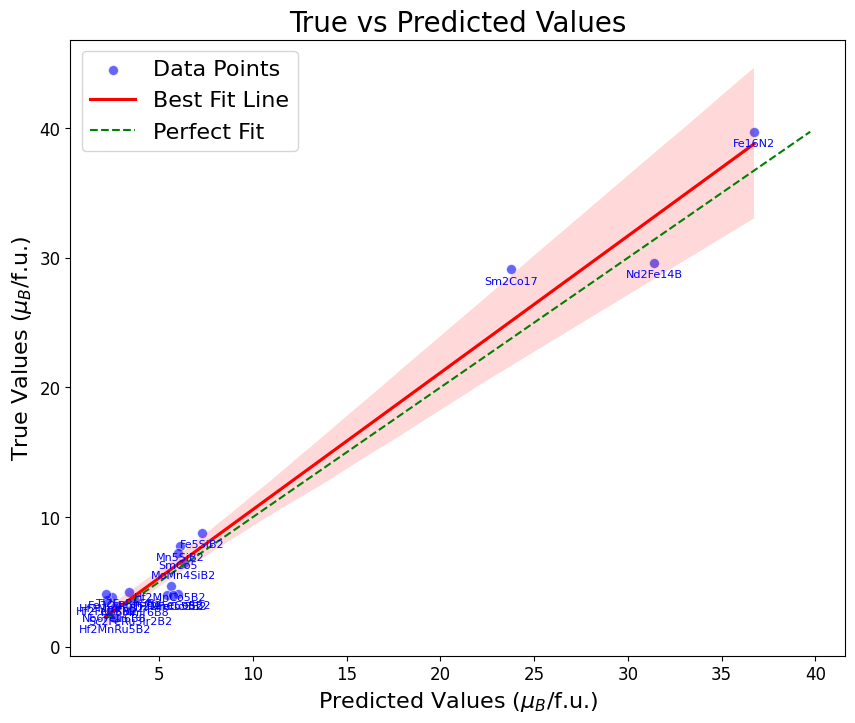

In [200]:
y_true = df_truth.total_magnetization_normalized_formula_units
y_true_formulas = df_truth.formula

plt.figure(figsize=(10, 8))

sns.scatterplot(x=y_pred, y=y_true, color='blue',
                alpha=0.6, s=50, label='Data Points')

for pred, true, formula in zip(y_pred, y_true, y_true_formulas):
    plt.text(pred, true - 0.5, formula, fontsize=8,
             ha='center', va='top', color='blue')

sns.regplot(x=y_pred, y=y_true, scatter=False,
            color='red', label='Best Fit Line')

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

plt.title('True vs Predicted Values')
plt.xlabel('Predicted Values ($\u03bc_B$/f.u.)')
plt.ylabel('True Values ($\u03bc_B$/f.u.)')
plt.legend()

plt.show()

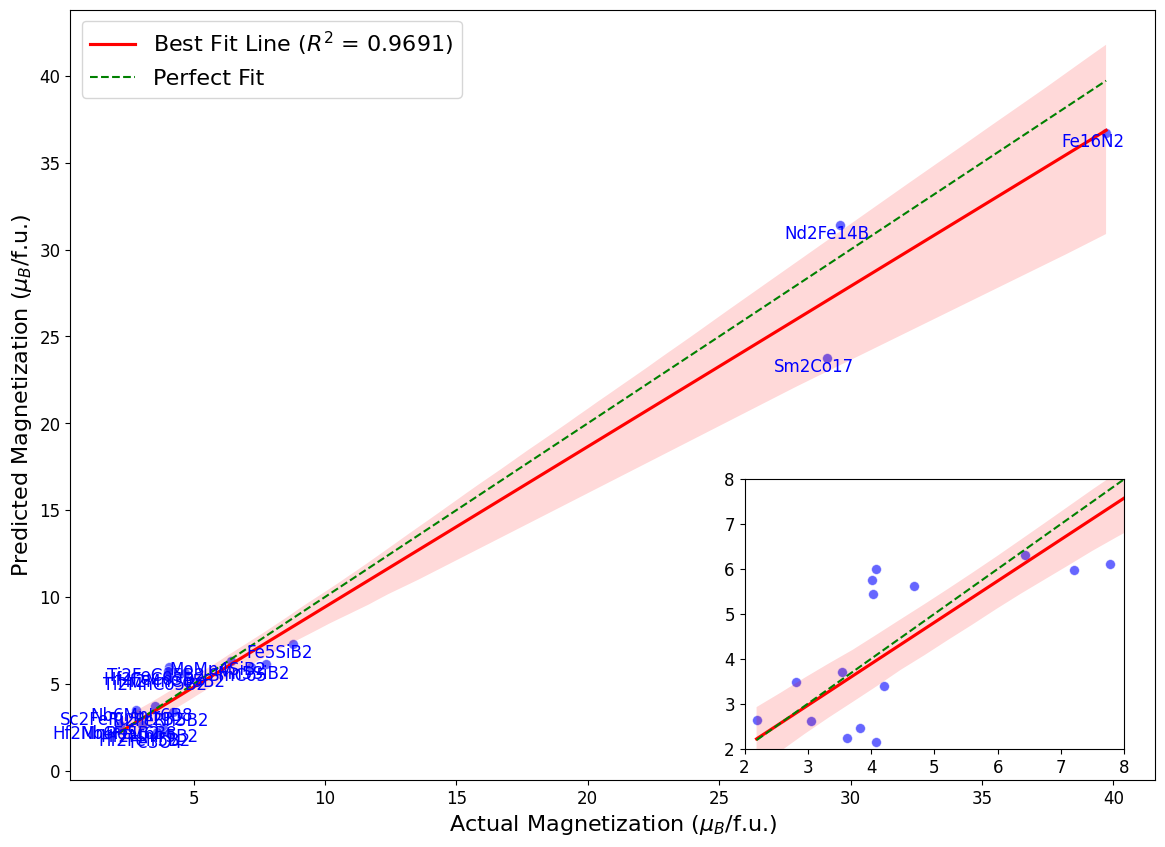

In [201]:
plt.figure(figsize=(14, 10))

r2 = r2_score(y_true, y_pred)

plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

sns.scatterplot(x=y_true, y=y_pred, color='blue',
                alpha=0.6, s=50)

for pred, true, formula in zip(y_pred, y_true, y_true_formulas):
    plt.text(true - 0.5, pred, formula, fontsize=12,
             ha='center', va='top', color='blue')

sns.regplot(x=y_true, y=y_pred, scatter=False,
            color='red', label=f'Best Fit Line ($R^2$ = {round(r2, 4)})')

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

plt.ylabel('Predicted Magnetization ($\u03bc_B$/f.u.)')
plt.xlabel('Actual Magnetization ($\u03bc_B$/f.u.)')
plt.legend()

inset_ax = inset_axes(plt.gca(), width="35%", height="35%",
                      loc='lower right', borderpad=1.4)

x_min, x_max = min(y_pred) - 0.1, max(y_pred) * 0.2
y_min, y_max = min(y_true) - 0.1, max(y_true) * 0.2

sns.scatterplot(x=y_true, y=y_pred, color='blue', alpha=0.6, s=50, ax=inset_ax)

sns.regplot(x=y_true, y=y_pred, scatter=False, color='red', ax=inset_ax)

plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)],
         color='green', linestyle='--', label='Perfect Fit')

inset_ax.set_ylim(2, 8)
inset_ax.set_xlim(2, 8)
inset_ax.set_xlabel(" ")

plt.show()

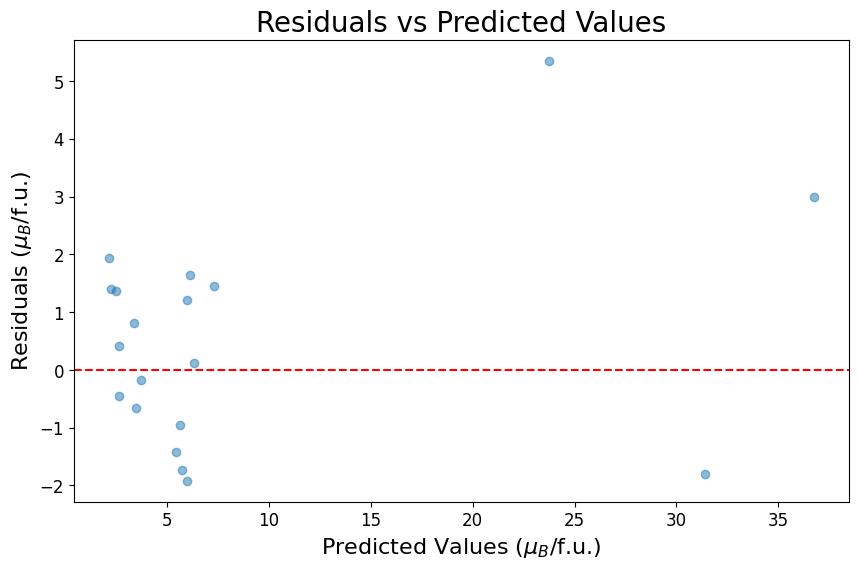

In [202]:
# Calculate residuals
residuals_reg = y_true - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals_reg, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values ($\u03bc_B$/f.u.)')
plt.ylabel('Residuals ($\u03bc_B$/f.u.)')
plt.title('Residuals vs Predicted Values')
plt.show()